# Resource Allocation for Demand Variability

This question relies on the demand predictions done in B1.

In [3]:
#pip install cvxpy

In [4]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns

In [5]:
## Load Data from B1 ##

df = pd.read_csv("output.csv")
scaler = StandardScaler()

# Standardize the variables to be used for deriving the response variable (demand score)
df[["Max_wait_time_std", "Total_units_std"]] = scaler.fit_transform(df[["Max_wait_time", "Total_units"]])
df.drop(columns=["Max_wait_time","Total_units"], inplace=True)

df["Demand_Score"] = (df["Max_wait_time_std"] + df["Total_units_std"]) / 2
df.drop(columns=["Max_wait_time_std","Total_units_std","Year_Month"], inplace=True)

# Final Dataset
df.head()

,Park_Fatalities_Previous_Year,Fraction of Not Rainy,Fraction of Rainy,Drought Count,Flooding Count,Freeze Count,Severe Storm Count,Tropical Cyclone Count,Wildfire Count,Winter Storm Count,...,Attraction_Spinning Coaster,Attraction_Spiral Slide,Attraction_Superman Ride,Attraction_Swing Ride,Attraction_Tilt-A-Whirl,Attraction_Top Spin,Attraction_Vertical Drop,Attraction_Water Ride,Attraction_Zipline,Demand_Score
0,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.267251
1,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.137697
2,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.375315
3,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.635457
4,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.002851


### Available Predictors

##### `output.csv` from B1
Data available:
1. Total fatalities in a year
2. Percentage of rainy & non-rainy days in a month
3. Count of Natural disasters in a year (severe storms, tropical cyclones, all disasters count. Drought, flooding, freeze, wildfire, winter storms are also considered but count is 0)
4. Number of public holidays in a month
5. 4 seasons (spring, summer, autumn, winter)
6. Ongoing disasters in a month
7. Average count of night shows in a month & year
8. Market competition from another theme park
9. Type of attraction (bumper cars, bungee jump, circus train, crazy bus, crazy dance, dizzy dropper, drop tower, flying coaster, free fall, giant wheel, giga coaster, go-karts, gondola, haunted house, himalaya ride, inverted coaster, kiddie coaster, log flume, merry go round, mono rail, oz theatre, pirate ship, power tower, rapids ride, reverse bungee, roller coaster, scooby doo, skyway, slingshot, spinning coaster, spiral slide, superman ride, swing ride, tilt-a-whirl, top spin, vertical drop, water ride, zipline)
10. Demand score (Min: -0.7258371417756044, Max: 3.9966205053726758)

##### `attendance.csv` from A5
Data available:
1. Attendance by month
2. Attendance by day
3. Attendance on public holidays vs non-holidays across 2 theme parks

### Demand Prediction (from B1)

From B1, we have concluded that Random Forest Regressor will be our final predictive model for demand prediction.

In [6]:
# Features and target variable
X = df.drop(columns=["Demand_Score"])  # Features
y = df["Demand_Score"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifying split sizes
print(f"Training data size: {X_train.shape[0]} samples")
print(f"Test data size: {X_test.shape[0]} samples")

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # different from B1 code

y_pred_rf = rf_model.predict(X_test)

# Test RMSE
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Test MAE
mae_test_rf = mean_absolute_error(y_test, y_pred_rf)
# R squared
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Test RMSE for Random Forest: {rmse_test_rf:.4f}")
print(f"Test MAE for Random Forest: {mae_test_rf:.4f}")
print(f"R-squared (R²): {r2_rf:.4f}")

Training data size: 1662 samples
Test data size: 416 samples
Test RMSE for Random Forest: 0.4966
Test MAE for Random Forest: 0.3254
R-squared (R²): 0.5769


## Optimization

Convex Optimization has been used as this optimization problem is a dynamic one.

**(Current) Optimization Problem: Minimize the total number of staff required in a theme park**

Assumptions that have been made:
- Each staff can serve 20 guests
- All staff members incur the same cost to the theme park, hence costs can be omitted from the model
- **Hypothetical data has been used for now**
- There are some staff required during park closing hours

Data required:
- predicted demand for each month
- average predicted surge in attendance during all special events
- average peak periods in a day, surge in each hour

### Optimization Model

**Suggestion**
If theme park hourly attendance data is not publicly available, maybe can consider looking for analogous domains where hourly footfall is tracked (like retail), then modify to resemble theme park attendance?

In [7]:
### Use hypothetical data for now. Replace with our predictions. Starts here. ###

# Sample Data: Predicted Demand for Each Hour, Month, and Special Events
np.random.seed(42)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
hours = list(range(24))  # for 24 hours

# Generate synthetic demand with seasonality and special events
data = []
for month in months:
    for day in days:
        for hour in hours:
            base_demand = np.random.randint(50, 300)  # Base demand
            event_multiplier = np.random.choice([1, 1.5], p=[0.8, 0.2])  # 20% chance of event surge
            peak_multiplier = 1.5 if hour in [12, 18, 20] else 1  # Higher demand at peak hours
            day_multiplier = 1.2 if day in ['Sat', 'Sun'] else 1
            demand = base_demand * event_multiplier * peak_multiplier * day_multiplier
            special_event = "Yes" if event_multiplier > 1 else "No"
            data.append([month, day, hour, special_event, demand])

df = pd.DataFrame(data, columns=['Month', 'Day', 'Hour', 'Special_Event', 'Predicted_Demand'])

### Use hypothetical data for now. Replace with our predictions. Ends here. ###


# Decision variables for staffing per month and hour
staff = {(month, day, hour): cp.Variable(nonneg=True) for month in months for day in days for hour in hours}

# Define objective function: Minimize total number of staff
objective = cp.Minimize(cp.sum([staff[month, day, hour] for month in months for day in days for hour in hours]))

# Constraints: Ensure sufficient staff for predicted demand
constraints = []
for month, day, hour in staff.keys():
    demand = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour)]['Predicted_Demand'].values[0]
    constraints.append(staff[month, day, hour] >= demand / 20) # Assumption: each staff can serve 20 guests

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Check if the problem was solved successfully
if problem.status == cp.OPTIMAL:

    # Extract optimized staffing
    optimized_staffing = {(month, day, hour): staff[month, day, hour].value for month in months for day in days for hour in hours}

    # Convert results into DataFrame for visualization
    staff_schedule = pd.DataFrame([(month, day, hour, v) for (month, day, hour), v in optimized_staffing.items()],
                                  columns=['Month', 'Day', 'Hour', 'Staff'])

    # Visualization
    def plot_staffing(month, day):
        if month not in months or day not in days:
            print("Invalid input for month and day.")
            return
        
        plot_data = staff_schedule[(staff_schedule['Month'] == month) & (staff_schedule["Day"] == day)]

        plt.figure(figsize = (10,5))
        sns.barplot(data=plot_data, x="Hour", y="Staff", hue="Staff")
        plt.title(f"Optimized Staffing for {day} in {month}")
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Staff")
        plt.xticks(range(24))
        plt.show

else:
    print("Optimization failed:", problem.status)

### Model Results

To get the optimized staffing for a certain month and day of the week, key in the first 3 letters of month and day into the function `plot_staffing`.

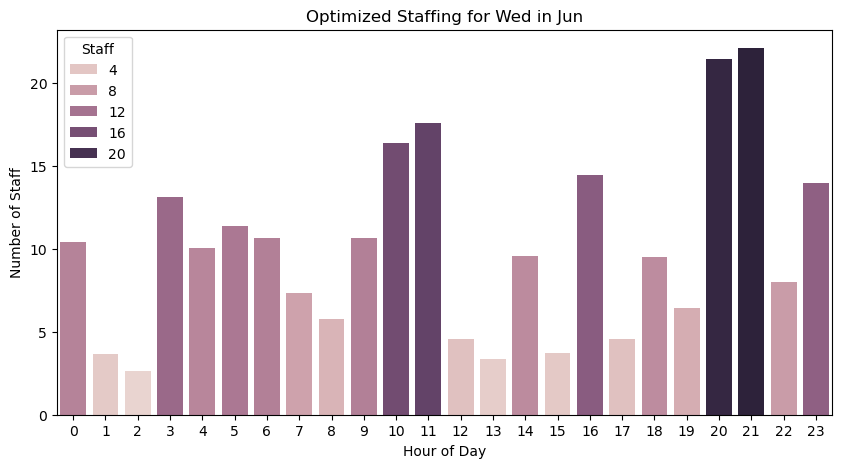

In [8]:
plot_staffing('Jun', 'Wed')

## Archives

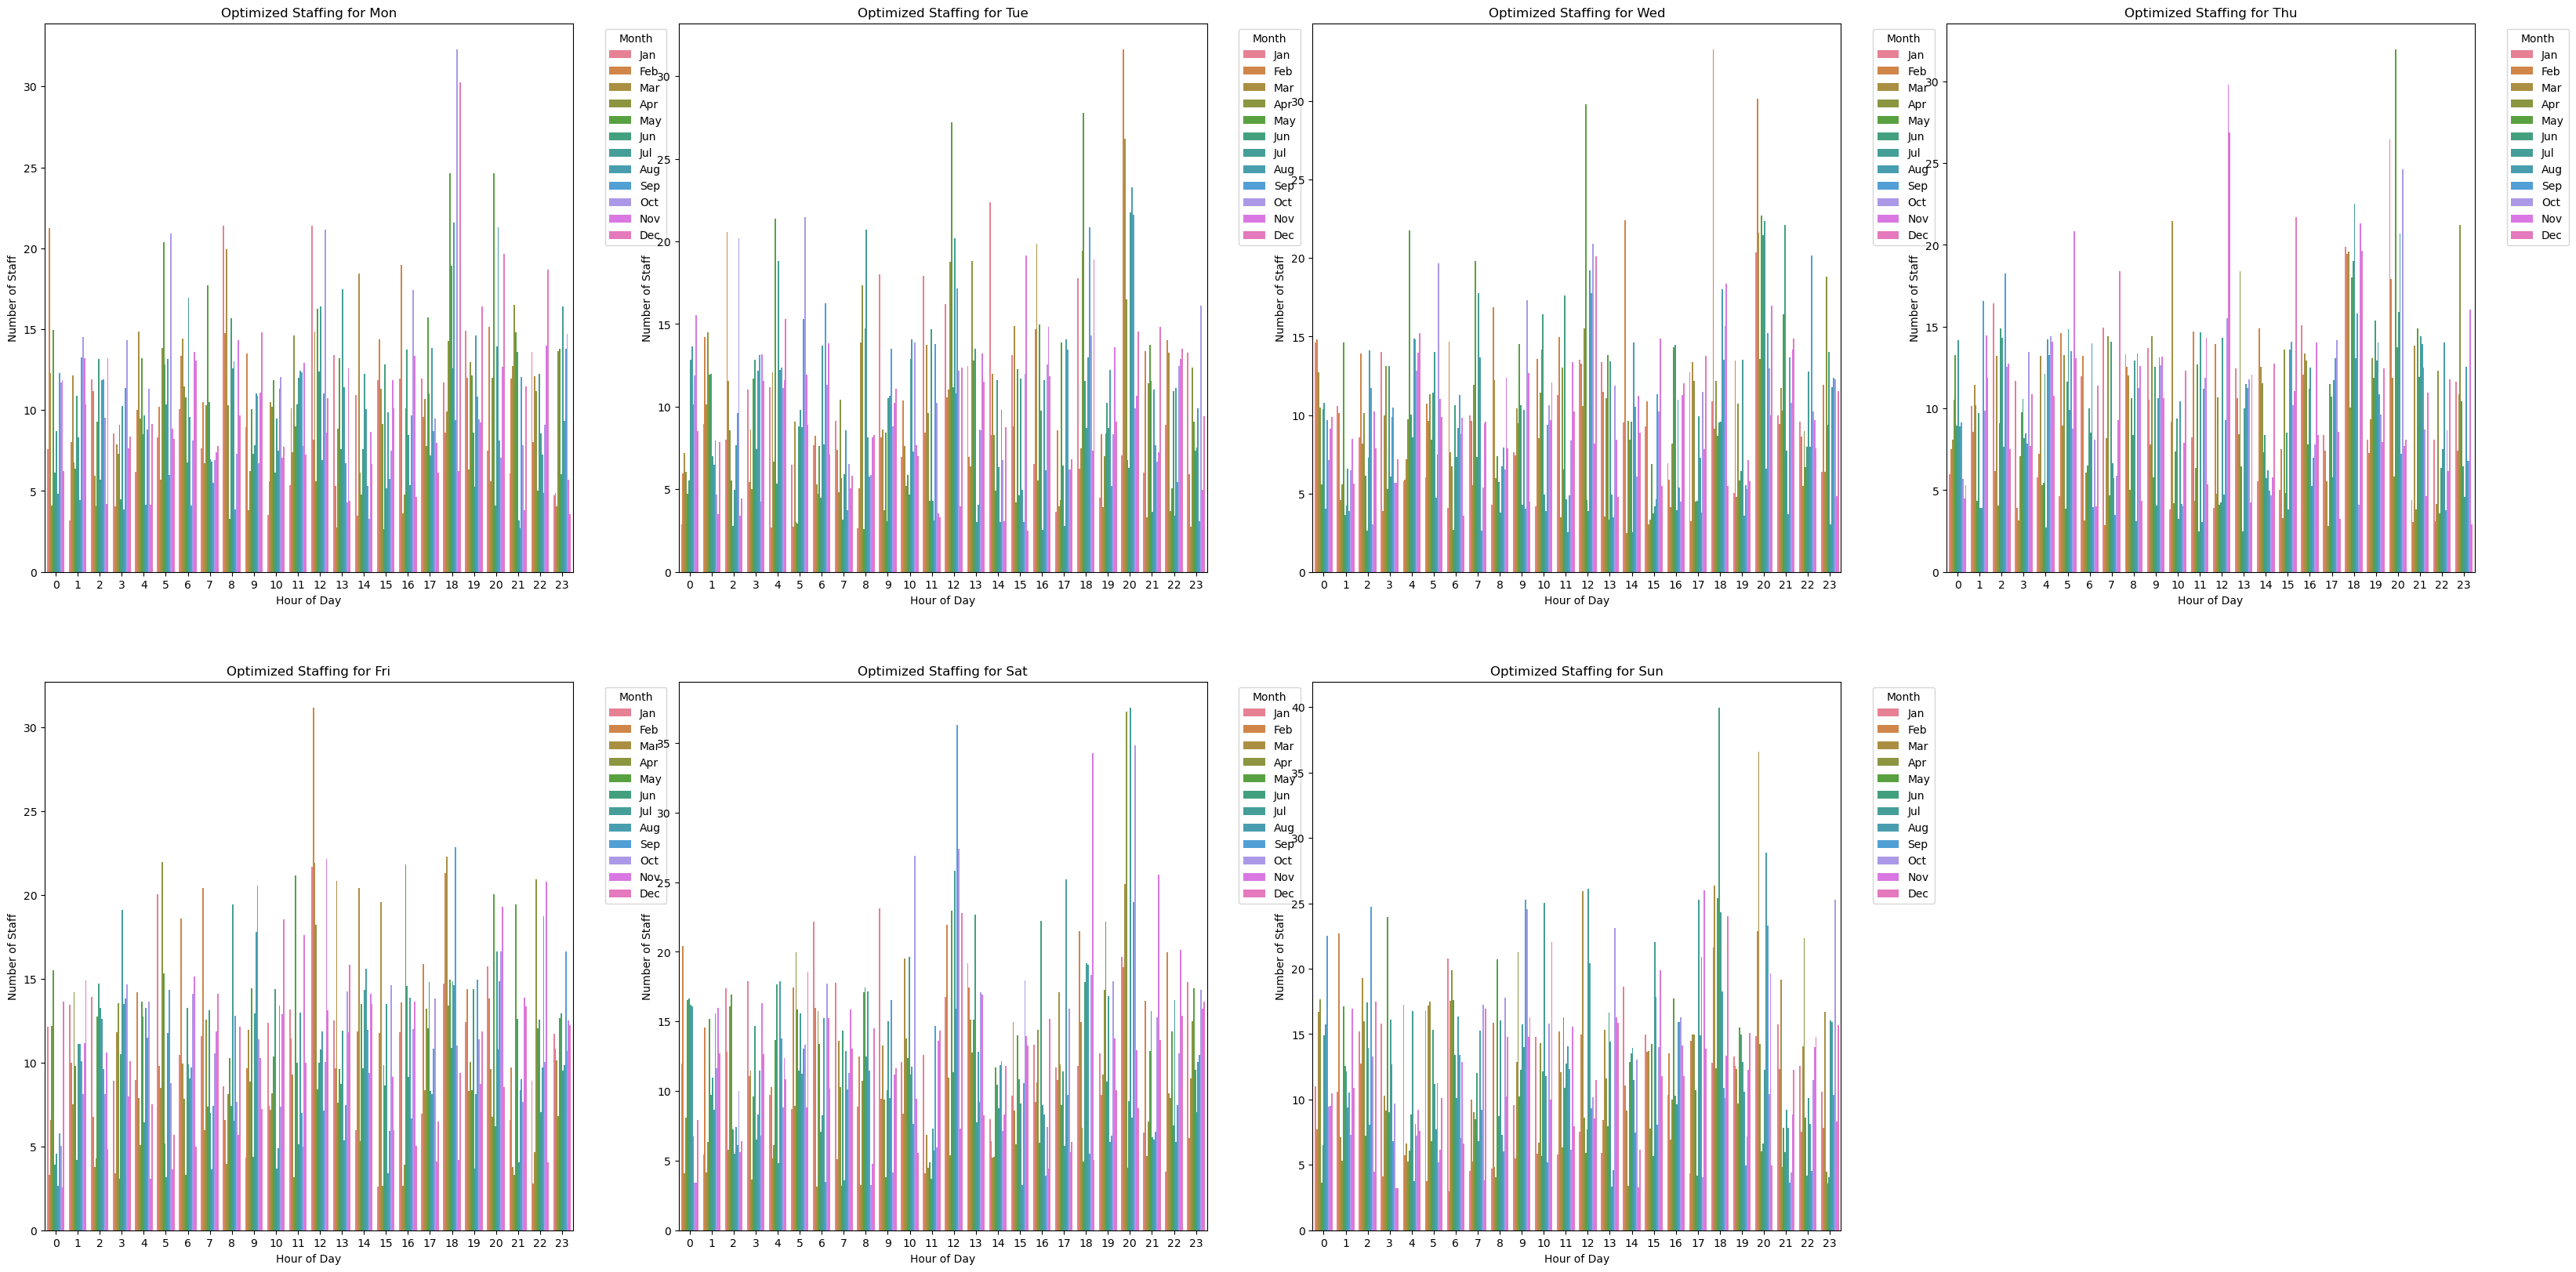

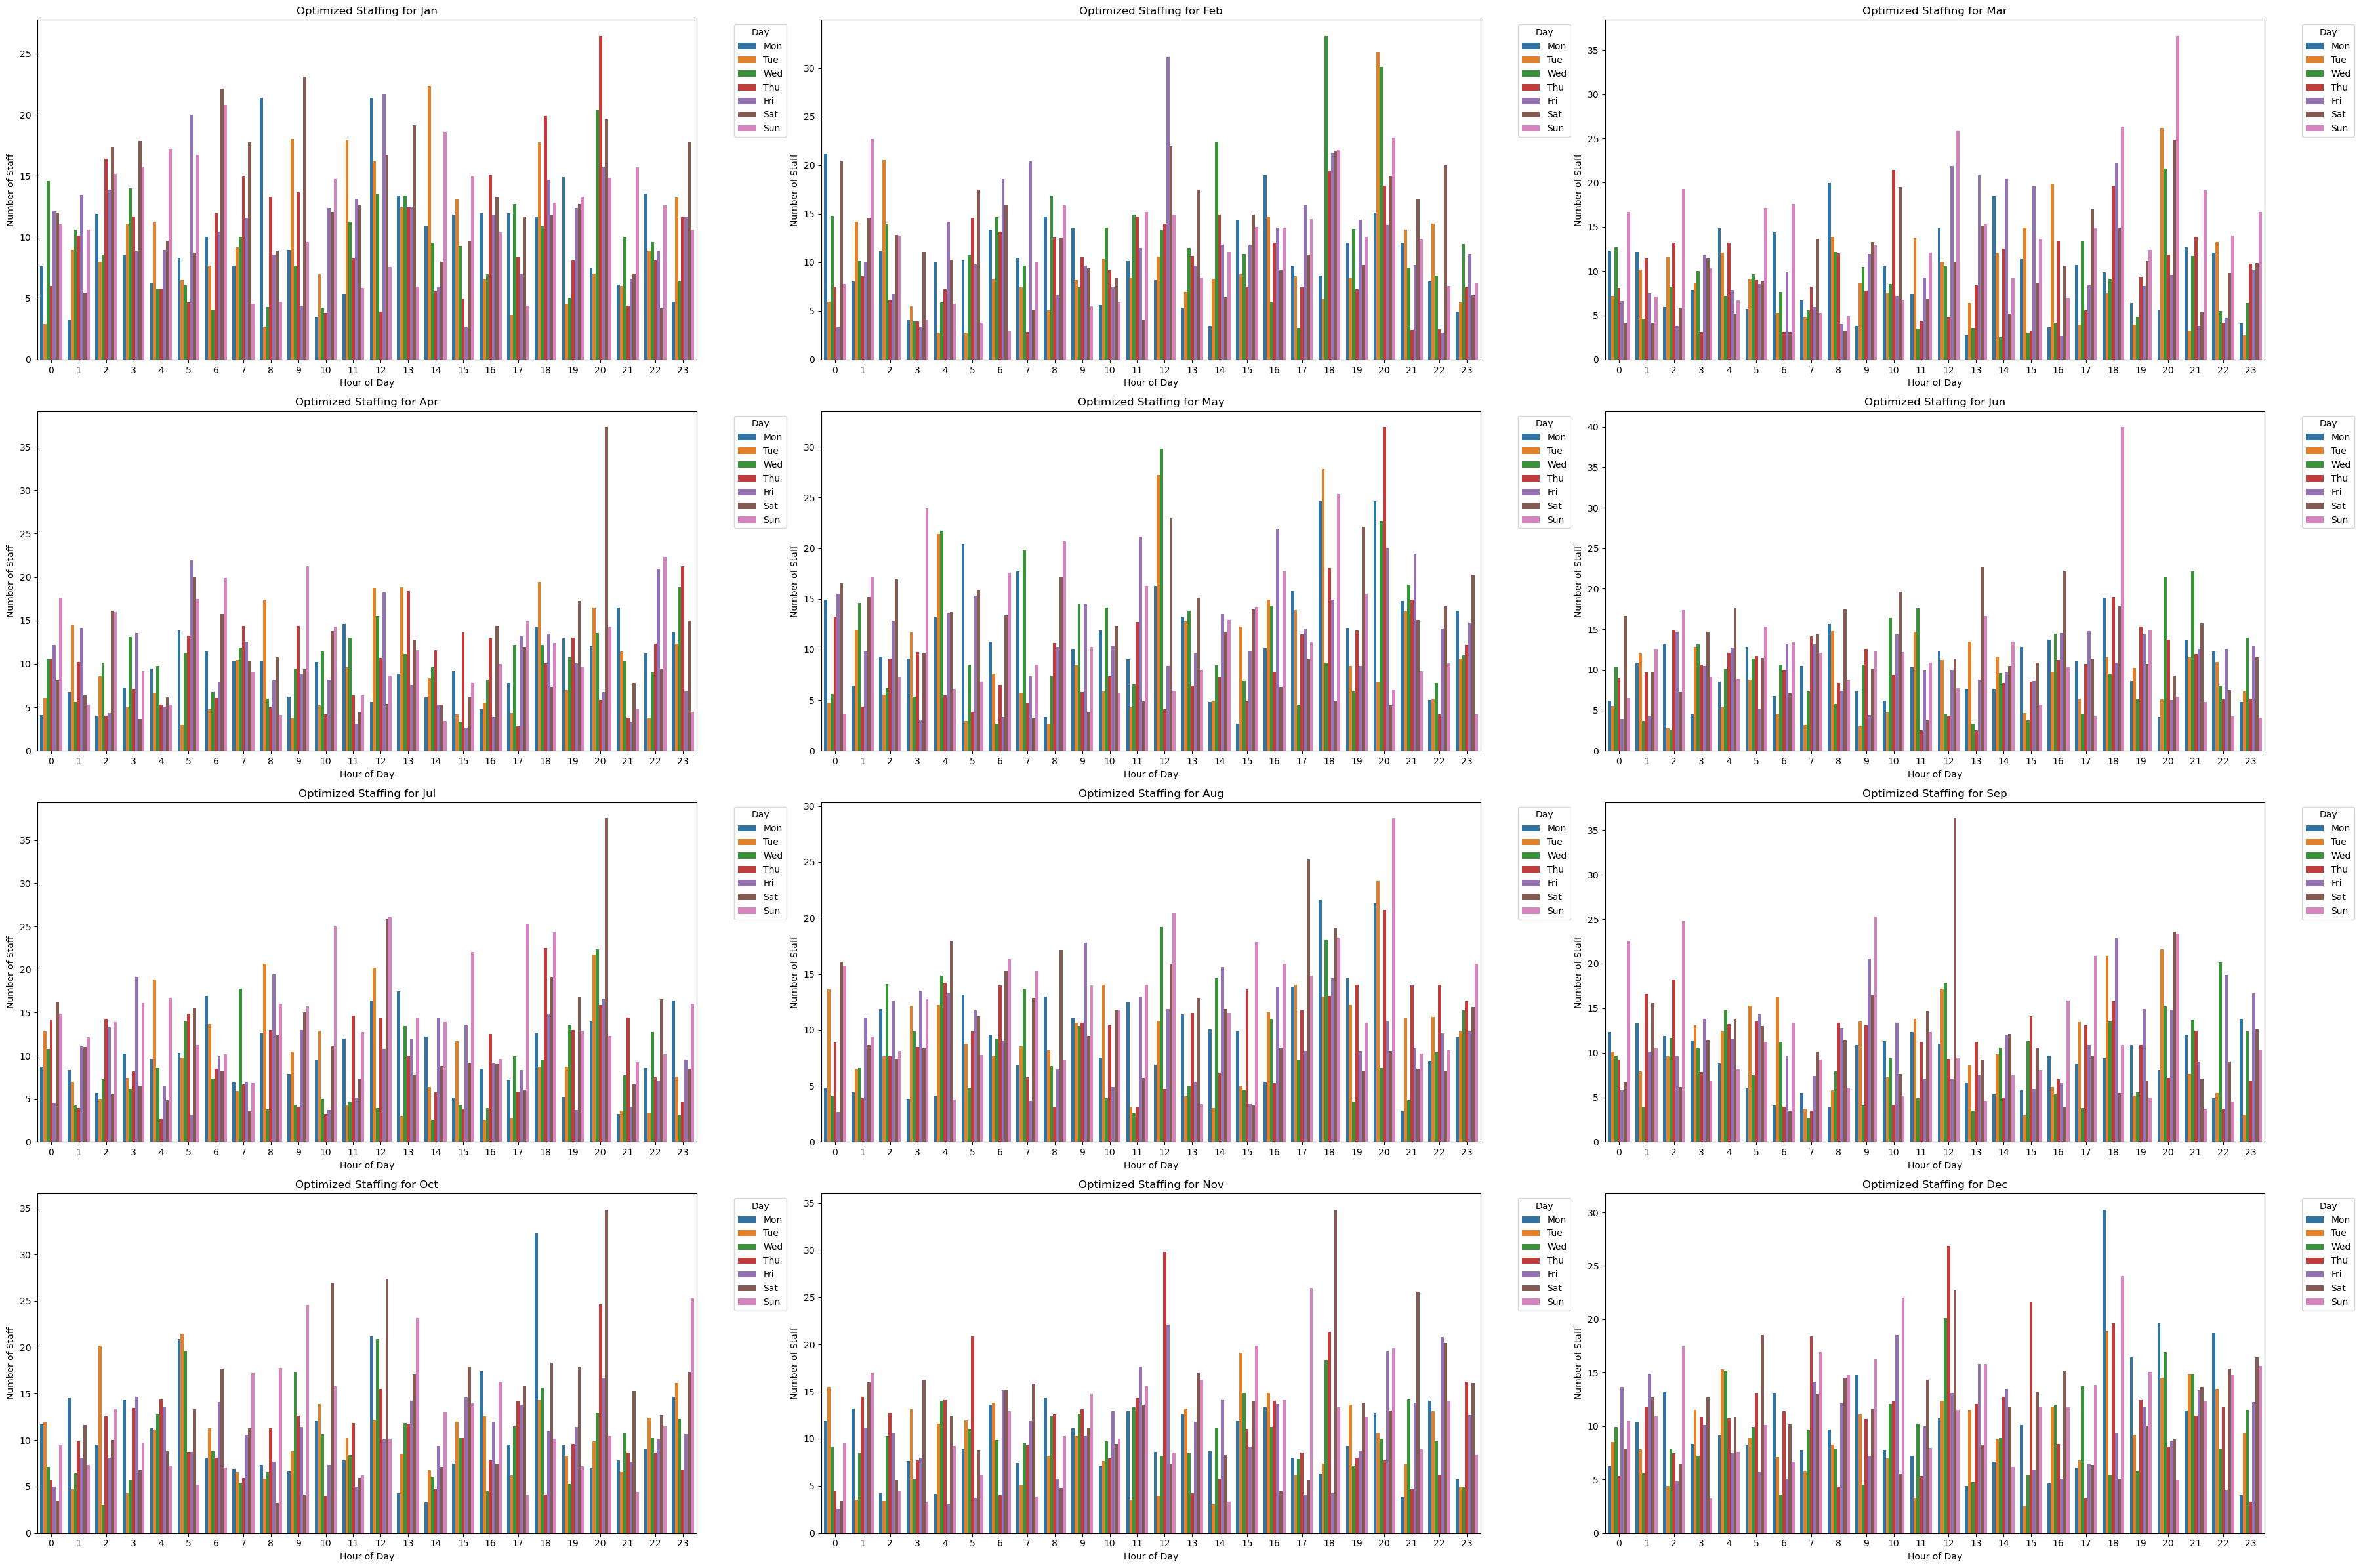

In [9]:
# Check if the problem was solved successfully
if problem.status == cp.OPTIMAL:

    # Extract optimized staffing
    optimized_staffing = {(month, day, hour): staff[month, day, hour].value for month in months for day in days for hour in hours}

    # Convert results into DataFrame for visualization
    staff_schedule = pd.DataFrame([(month, day, hour, v) for (month, day, hour), v in optimized_staffing.items()],
                                  columns=['Month', 'Day', 'Hour', 'Staff'])

    ## PLOTS ##
    # Create 7 subplots (one per day of the week)
    fig, axes = plt.subplots(2, 4, figsize=(40, 20))  # 2 rows x 4 columns (1 extra empty)
    axes = axes.flatten()

    for i, day in enumerate(days):
        ax = axes[i]
        sns.barplot(data=staff_schedule[staff_schedule["Day"] == day], x="Hour", y="Staff", hue="Month", ax=ax)
        ax.set_title(f"Optimized Staffing for {day}")
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Number of Staff")
        ax.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Hide the extra subplot
    fig.delaxes(axes[-1])  

    ## OR ##

    # Create 12 subplots (one per month)
    fig, axes = plt.subplots(4, 3, figsize=(36, 24))
    axes = axes.flatten()

    for i, month in enumerate(months):
        ax = axes[i]
        sns.barplot(data=staff_schedule[staff_schedule['Month'] == month], x="Hour", y="Staff", hue="Day", ax=ax)
        ax.set_title(f"Optimized Staffing for {month}")
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Number of Staff")
        ax.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')



    plt.tight_layout()
    plt.show()

else:
    print("Optimization failed:", problem.status)